<a href="https://colab.research.google.com/github/diarrabell/Carbon-Farming/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
! pip install torch torchvision torchaudio
! pip install -Uq kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import time
import copy
import shutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path

## Download Dataset from Kaggle

1.  First set up the Kaggle API and download kaggle.json using these instructions: https://github.com/Kaggle/kaggle-api
2.   Run the following cell and upload kaggle.json


In [3]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"diarrabell","key":"ae3140768a2f7c513228f073eb9ec167"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
# ! rm -r /content/planet

In [6]:
! kaggle datasets download nikitarom/planets-dataset

planets-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

### Load the Dataset

In [8]:
path = Path('./planet/planet')
train_df = pd.read_csv(path/'train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


## Prepare data for modeling

We know there are 17 total labels. Select the labels we think are most responsible for deforestation - agriculture, slash-burn, habitation, selective-logging, artisinal_mine, conventional_mine, cultivation

In [9]:
deforestation_labels = ['agriculture', 'slash-burn', 'habitation', 'selective-logging',  'artisinal_mine', 'conventional_mine', 'cultivation']

Since we're focusing on deforestation/green, select conserved labels as well. 

In [10]:
conserved_labels = ['primary']

### Combine these labels to create the binary class 'deforestation' - 0 for conserved, 1 if conservation is detected.

#### If any of the deforestation labels are found in an image's tags, deforestation = 1. Otherwise, deforestation = 0.

In [11]:
train_df['deforestation'] = 0

tag = train_df['tags']
print(type(tag[0]))

deforested = tag.str.contains('|'.join(deforestation_labels))
train_df['deforestation'] = deforested.astype(int)
     
display(train_df.head())
print(len(train_df))

#if tags contains any label from deforestation_labels, it has a postive value of deforestation (1)

<class 'str'>


,image_name,tags,deforestation
0,train_0,haze primary,0
1,train_1,agriculture clear primary water,1
2,train_2,clear primary,0
3,train_3,clear primary,0
4,train_4,agriculture clear habitation primary road,1


40479


In [12]:
# dataframe for validation set- 20% of data
val_df = train_df.iloc[:8096]
display(val_df.head())
display(val_df.tail())

,image_name,tags,deforestation
0,train_0,haze primary,0
1,train_1,agriculture clear primary water,1
2,train_2,clear primary,0
3,train_3,clear primary,0
4,train_4,agriculture clear habitation primary road,1


,image_name,tags,deforestation
8091,train_8091,agriculture habitation partly_cloudy primary,1
8092,train_8092,agriculture habitation partly_cloudy primary road,1
8093,train_8093,agriculture clear primary,1
8094,train_8094,agriculture clear primary road selective_logging,1
8095,train_8095,clear primary,0


In [13]:
# dataframe for training set - 80% of data
train_df = train_df.iloc[8096:]
display(train_df.head())
display(train_df.tail())

,image_name,tags,deforestation
8096,train_8096,clear primary road water,0
8097,train_8097,clear water,0
8098,train_8098,clear primary,0
8099,train_8099,clear primary,0
8100,train_8100,cloudy,0


,image_name,tags,deforestation
40474,train_40474,clear primary,0
40475,train_40475,cloudy,0
40476,train_40476,agriculture clear primary,1
40477,train_40477,agriculture clear primary road,1
40478,train_40478,agriculture cultivation partly_cloudy primary,1


## Store images in a PyTorch Dataset


In [14]:
! mkdir /content/planet/planet/data
! mv /content/planet/planet/train-jpg /content/planet/planet/data/train-jpg
! mkdir /content/planet/planet/validation/
! mkdir /content/planet/planet/validation/validation-jpg
# ! mv /content/planet/planet/test-jpg /content/planet/planet/validation/test-jpg

# 20% of data will be validation set


In [15]:
#### creating validation set
#8096 == 20% of 40479

old_path = '/content/planet/planet/data/train-jpg/train_{0..8095}.jpg'
new_path = '/content/planet/planet/validation/validation-jpg/'
! mv $old_path $new_path

#### Separate the images into the two classes - deforested and conserved 



In [16]:
! mkdir /content/planet/planet/data/conserved 
! mkdir /content/planet/planet/data/deforested
! mkdir /content/planet/planet/validation/conserved
! mkdir /content/planet/planet/validation/deforested

## training data 
train_conserved_img = train_df[train_df['deforestation'] == 0]['image_name']
train_conserved_img = list(train_conserved_img + '.jpg')

source_folder = '/content/planet/planet/data/train-jpg/'
destination_folder = '/content/planet/planet/data/conserved/'
files_to_move = train_conserved_img

for file in files_to_move:
    # construct full file path
    source = source_folder + file
    destination = destination_folder + file
    # move file
    shutil.move(source, destination)


train_deforested_img = train_df[train_df['deforestation'] == 1]['image_name']
train_deforested_img = list(train_deforested_img + '.jpg')
source_folder = '/content/planet/planet/data/train-jpg/'
destination_folder = '/content/planet/planet/data/deforested/'
files_to_move = train_deforested_img

for file in files_to_move:
    # construct full file path
    source = source_folder + file
    destination = destination_folder + file
    # move file
    shutil.move(source, destination)
   


In [17]:
# validation data 
val_conserved_img = val_df[val_df['deforestation'] == 0]['image_name']
val_conserved_img = list(val_conserved_img + '.jpg')
val_deforested_img = val_df[val_df['deforestation'] == 1]['image_name']
val_deforested_img = list(val_deforested_img + '.jpg')

source_folder = '/content/planet/planet/validation/validation-jpg/'
destination_folder = '/content/planet/planet/validation/conserved/'
files_to_move = val_conserved_img

for file in files_to_move:
    # construct full file path
    source = source_folder + file
    destination = destination_folder + file
    # move file
    shutil.move(source, destination)

source_folder = '/content/planet/planet/validation/validation-jpg/'
destination_folder = '/content/planet/planet/validation/deforested/'
files_to_move = val_deforested_img

for file in files_to_move:
    # construct full file path
    source = source_folder + file
    destination = destination_folder + file
    # move file
    shutil.move(source, destination)




In [18]:
! rm -r '/content/planet/planet/validation/validation-jpg'
! rm -r '/content/planet/planet/data/train-jpg'

In [19]:
#We are using a binary classification model, so our image classes are 1 - significant deforestation; 0 - no significant deforestation
#Setting up transforms
data_transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#Set up dataset for training set and validation set 
train_data = datasets.ImageFolder('/content/planet/planet/data/', transform = data_transform)
val_data = datasets.ImageFolder('/content/planet/planet/validation', transform=data_transform)

#check to make sure number of images and df rows is the same
print('Training data images: ', len(train_data))
print('Training data csv: ', len(train_df))
print('Validation data images: ', len(val_data))

print(train_data, val_data)

# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

Training data images:  32383
Training data csv:  32383
Validation data images:  8096
Dataset ImageFolder
    Number of datapoints: 32383
    Root location: /content/planet/planet/data/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ) Dataset ImageFolder
    Number of datapoints: 8096
    Root location: /content/planet/planet/validation
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


## Setting up dataloaders

In [20]:
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
dataloaders = {'train':train_loader, 'val':val_loader}
dataset_sizes = {'train':len(train_data), 'val':len(val_data)}
class_names = train_data.classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Plot the images in the batch

torch.Size([128, 3, 256, 256])


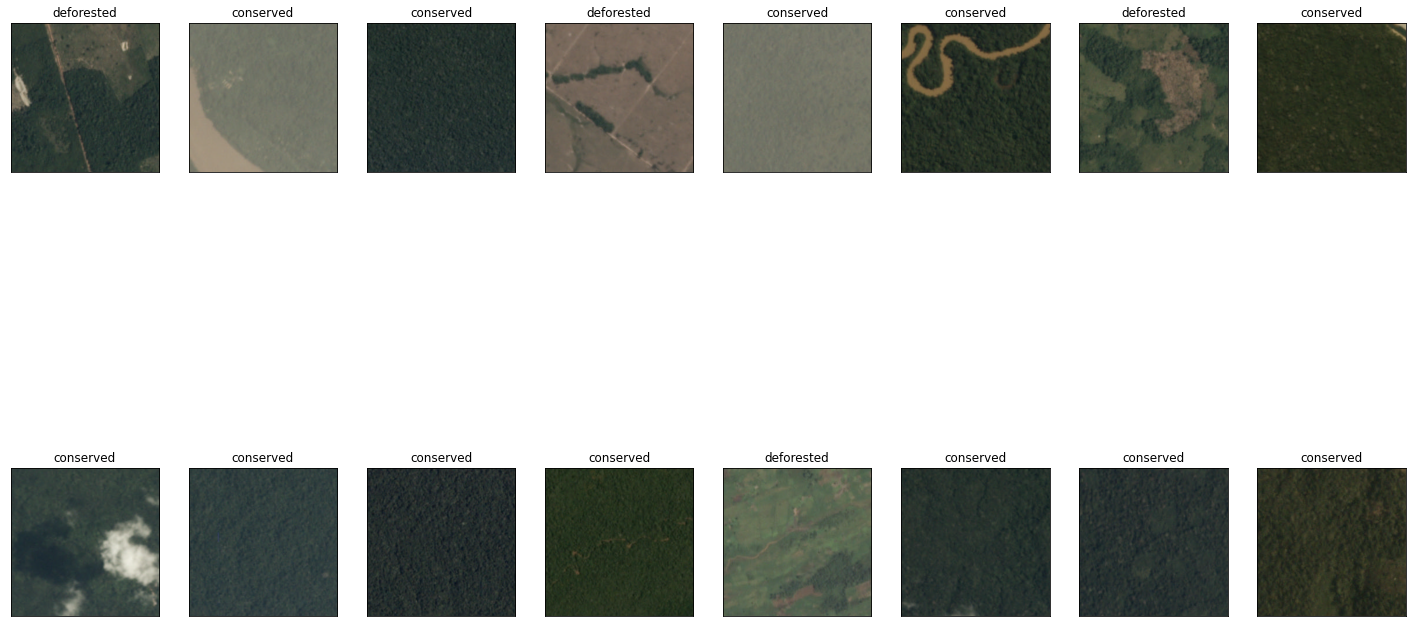

In [21]:
images, labels = iter(train_loader).next()
print(images.shape)
images = images.numpy()

fig = plt.figure(figsize=(25, 15))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.225, 0.225, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{}".format(class_names[labels[idx]]))

# train_df['deforestation'].head(24)

### Define model architecture

In [22]:
net = torchvision.models.resnet18(pretrained=True)
for param in net.parameters():
  param.requires_grad = False

summary(net, (images.shape[1:]), batch_size=batch_size, device='cpu')

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [128, 64, 128, 128]           9,408
       BatchNorm2d-2        [128, 64, 128, 128]             128
              ReLU-3        [128, 64, 128, 128]               0
         MaxPool2d-4          [128, 64, 64, 64]               0
            Conv2d-5          [128, 64, 64, 64]          36,864
       BatchNorm2d-6          [128, 64, 64, 64]             128
              ReLU-7          [128, 64, 64, 64]               0
            Conv2d-8          [128, 64, 64, 64]          36,864
       BatchNorm2d-9          [128, 64, 64, 64]             128
             ReLU-10          [128, 64, 64, 64]               0
       BasicBlock-11          [128, 64, 64, 64]               0
           Conv2d-12          [128, 64, 64, 64]          36,864
      BatchNorm2d-13          [128, 64, 64, 64]             128
             ReLU-14          [128, 64,

In [23]:
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 2)

### Define a cost/loss function and optimizer

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)

### Using pre-trained model

In [25]:
from math import sin
def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=25):
  model = model.to(device)
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  loss_over_time = []

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    running_loss = 0.0

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)

          # Backpropagation to get the gradients with respect to each weight
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)



      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]
      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()
  
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:3f}'.format(best_acc))

  model.load_state_dict(best_model_wts)

  return model

### Train model (takes approximately 25 min to run with GPU)

In [26]:
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = train_model(net, criterion, optimizer, dataloaders, lr_scheduler, device, num_epochs=10)

Epoch 0/9
----------
train Loss: 0.3722 Acc: 0.8423
val Loss: 0.3164 Acc: 0.8735

Epoch 1/9
----------
train Loss: 0.3047 Acc: 0.8783
val Loss: 0.3123 Acc: 0.8691

Epoch 2/9
----------
train Loss: 0.2962 Acc: 0.8831
val Loss: 0.2990 Acc: 0.8764

Epoch 3/9
----------
train Loss: 0.2903 Acc: 0.8844
val Loss: 0.2981 Acc: 0.8764

Epoch 4/9
----------
train Loss: 0.2872 Acc: 0.8873
val Loss: 0.2945 Acc: 0.8782

Epoch 5/9
----------
train Loss: 0.2848 Acc: 0.8872
val Loss: 0.2921 Acc: 0.8796

Epoch 6/9
----------
train Loss: 0.2827 Acc: 0.8888
val Loss: 0.2945 Acc: 0.8782

Epoch 7/9
----------
train Loss: 0.2769 Acc: 0.8913
val Loss: 0.2935 Acc: 0.8777

Epoch 8/9
----------
train Loss: 0.2765 Acc: 0.8914
val Loss: 0.2916 Acc: 0.8793

Epoch 9/9
----------
train Loss: 0.2765 Acc: 0.8925
val Loss: 0.2926 Acc: 0.8785

Training complete in 20m 41s
Best val Acc: 0.879570


In [27]:
#save the model
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
filename = 'resnet18.pt'
torch.save(net, os.path.join(model_dir,filename))

### Visualize Results

In [28]:
def visualize_results(model, dataloader, device):
  model = model.to(device)
  with torch.no_grad():
    model.eval()
    images, labels = iter(val_loader).next()
    images, labels = images.to(device), labels.to(device)
    _, preds = torch.max(model(images), 1)
    preds = np.squeeze(preds.cpu().numpy())
    images = images.cpu().numpy()
  
  fig = plt.figure(figsize=(25, 15))
  for idx in np.arange(16):
    ax = fig.add_subplot(2, 16//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)
    ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
  return 

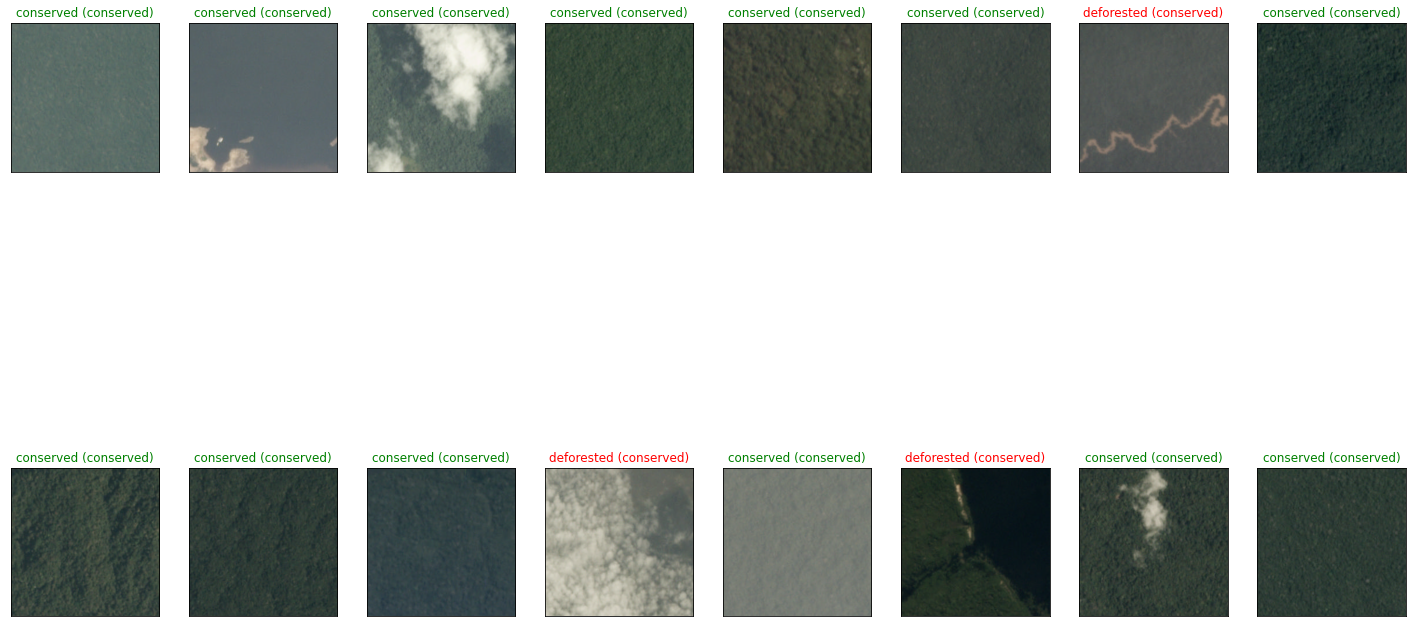

In [29]:
visualize_results(net, val_loader, device)

## Test model with Google Earth Engine data
### Import data from GitHub

In [32]:
repo = 'Carbon-Farming'
git_path = 'https://github.com/diarrabell/Carbon-Farming.git'
!git clone "{git_path}"

notebook_dir = 'test-data/'
path_to_notebook = os.path.join(repo, notebook_dir)
%cd "/content"
%ls

Cloning into 'Carbon-Farming'...
remote: Enumerating objects: 461, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 461 (delta 70), reused 81 (delta 37), pack-reused 340
Receiving objects: 100% (461/461), 62.70 MiB | 9.15 MiB/s, done.
Resolving deltas: 100% (216/216), done.
/content
 Carbon-Farming/    kaggle.json   planet/               sample_data/
'kaggle (1).json'   models/       planets-dataset.zip   test-jpg-additional/


### Create dataloaders

In [33]:
data_transform = transforms.Compose([transforms.Resize((224, 224)),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_data_nuflo = datasets.ImageFolder('/content/Carbon-Farming/test-data/nuflo/', transform=data_transform)
test_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=False, num_workers=2)
classes = ['deforested', 'conserved']


torch.Size([128, 3, 256, 256])


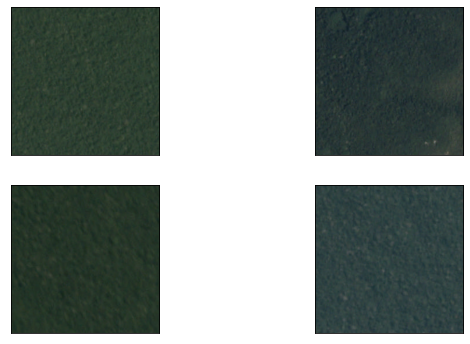

In [34]:
batch_size= 4
images, labels = iter(test_loader).next()
print(images.shape)
images = images.numpy()
fig = plt.figure(figsize=(10, 6))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    image = images[idx]
    image = image.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    ax.imshow(image)

## Test model

In [60]:
def test_model(model, test_loader, device):
  model = model.to(device)
  with torch.no_grad():
     model.eval()
     y_true = []
     test_preds = []
     test_probs = []

     for data in test_loader:
       inputs, labels = data[0].to(device), data[1].to(device)
       logits = net.forward(inputs)
       probs = F.softmax(logits, dim=1)
       probs = probs.detach().cpu().numpy()
       preds = np.argmax(probs, axis=1)
       test_preds.extend(preds)
       test_probs.extend(probs)
       y_true.extend(labels.detach().cpu().numpy())
    
     test_preds = np.array(test_preds)
     test_probs = np.array(test_probs)
     y_true = np.array(y_true)
     test_acc = np.sum(test_preds == y_true)/y_true.shape[0]

     recall_vals = []
     for i in range(2):
       class_idx = np.argwhere(y_true==i)
       total = len(class_idx)
       correct = np.sum(test_preds[class_idx]==i)
       recall = correct / total
       recall_vals.append(recall)

  return test_acc, recall_vals

In [61]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc,recall_vals = test_model(net,test_loader,device)
print('Test set accuracy is {:.3f}'.format(acc))
print('For class {}, recall is {}'.format(classes[0],recall_vals[0]))
print('For class {}, recall is {}'.format(classes[1],recall_vals[1]))

Test set accuracy is 0.894
For class deforested, recall is 0.9411764705882353
For class conserved, recall is 0.8095896328293737


In [1]:
# Display predictions

with torch.no_grad():
    net = net.to(device)
    net.eval()
    # Get a batch of test images
    dataiter = iter(val_loader)
    images, labels = dataiter.next()
    images, labels = images.to(device), labels.to(device)
    # get predictions
    preds = np.squeeze(net(images).max(1, keepdim=True)[1].cpu().numpy())
    images = images.cpu().numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(preds[idx], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

NameError: ignored